In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [ ]:
ticker = "AAPL"
data = yf.download(ticker, start="2013-01-01", end="2023-01-01")
# Select only the 'Close' and 'Volume' columns
data = data[['Close', 'Volume']]
print(data.head())
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
def create_sequences(data, seq_length):
    """
    Converts time series data into sequences for training an LSTM.

    Parameters:
      - data: Scaled 2D numpy array with features (Close, Volume)
      - seq_length: Number of past days to use as input for predicting the next day's Close price.

    Returns:
      - sequences: Tensor of shape (num_sequences, seq_length, num_features)
      - labels: Tensor of shape (num_sequences,) containing the target Close prices.
    """
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]      # The window of past data
        label = data[i + seq_length, 0]     # The target is the next day's Close price (first column)
        sequences.append(seq)
        labels.append(label)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

seq_length = 30  # Using the past 30 days to predict the next day’s Close price
X, y = create_sequences(scaled_data, seq_length)

# 4️⃣ Split Data into Training and Testing Sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5️⃣ Define the LSTM Model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        """
        Initializes the LSTM model.

        Parameters:
          - input_size: Number of features (2 for Close and Volume)
          - hidden_size: Number of features in the hidden state
          - num_layers: Number of stacked LSTM layers
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The LSTM layer processes the input sequence
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # A fully connected layer that maps the LSTM output to the final prediction
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden and cell states with zeros for each sequence in the batch
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Use the output from the last time step and pass it through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out


[*********************100%***********************]  1 of 1 completed

Price           Close     Volume
Ticker           AAPL       AAPL
Date                            
2013-01-02  16.669012  560518000
2013-01-03  16.458614  352965200
2013-01-04  16.000166  594333600
2013-01-07  15.906047  484156400
2013-01-08  15.948852  458707200


In [ ]:
input_size = 2   # Close and Volume
hidden_size = 64
num_layers = 2
model = LSTMModel(input_size, hidden_size, num_layers)

# 6️⃣ Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7️⃣ Train the Model
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.6f}")
# 8️⃣ Evaluate and Make Predictions
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
# 9️⃣ Convert Predictions Back to Actual Prices
# We need to invert the normalization for the Close price (first column)
y_test_actual = scaler.inverse_transform(np.column_stack((y_test.numpy(), np.zeros(len(y_test)))))[:, 0]
predictions_actual = scaler.inverse_transform(np.column_stack((predictions.numpy(), np.zeros(len(predictions)))))[:, 0]


Epoch 10, Loss: 0.022670
Epoch 20, Loss: 0.018976
Epoch 30, Loss: 0.013764
Epoch 40, Loss: 0.001931
Epoch 50, Loss: 0.001066


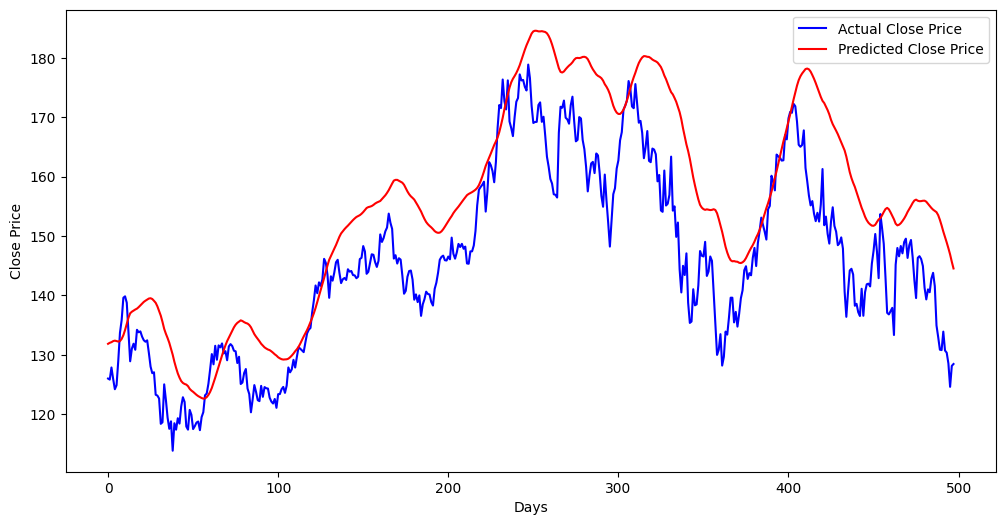

Mean Squared Error (MSE): 141.795667
Root Mean Squared Error (RMSE): 11.907799
Mean Absolute Error (MAE): 9.839449
R-squared (R2): 0.402110


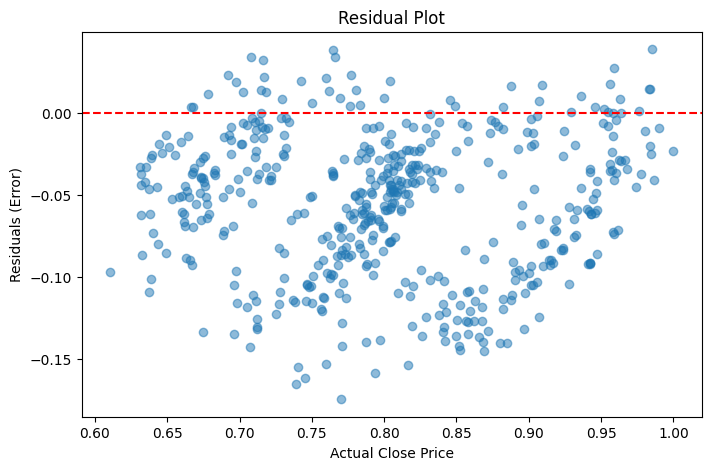

In [ ]:
# 🔟 Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Close Price", color="blue")
plt.plot(predictions_actual, label="Predicted Close Price", color="red")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.legend()
plt.show()
# Calculate the metrics
mse = mean_squared_error(y_test_actual, predictions_actual)
rmse = np.sqrt(mse)  # or use mean_squared_error(y_test_actual, predictions_actual, squared=False)
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

# Print the results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R2): {r2:.6f}")
plt.figure(figsize=(8, 5))
residuals = y_test.numpy() - predictions.numpy()
plt.scatter(y_test.numpy(), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Add a reference line at 0
plt.xlabel("Actual Close Price")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()



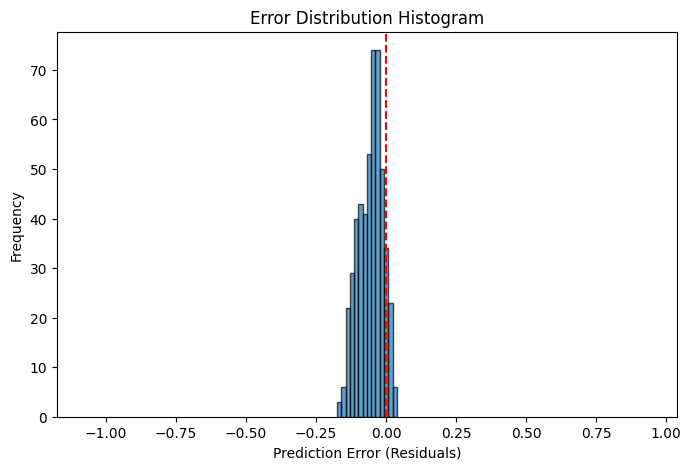

Epoch 10, Train Loss: 0.000397, Val Loss: 0.012827
Epoch 20, Train Loss: 0.000260, Val Loss: 0.001455
Epoch 30, Train Loss: 0.000242, Val Loss: 0.001447
Epoch 40, Train Loss: 0.000219, Val Loss: 0.001466
Epoch 50, Train Loss: 0.000198, Val Loss: 0.001426


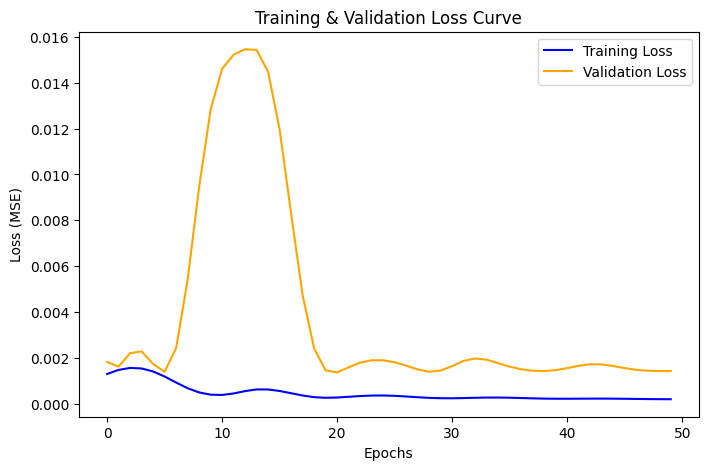

In [ ]:
plt.figure(figsize=(8, 5))
bins = np.histogram_bin_edges(residuals, bins='auto')  # Auto-adjusted bin width
plt.hist(residuals, bins=bins, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')  # Reference line at zero
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Error Distribution Histogram")
plt.xlim(residuals.min() - 1, residuals.max() + 1)  # Adjust limits for better visibility
plt.show()

train_losses = []
val_losses = []

epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    train_loss = criterion(output.squeeze(), y_train)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())  # Store training loss

    # Validation Loss (without gradient tracking)
    model.eval()
    with torch.no_grad():
        val_output = model(X_test)
        val_loss = criterion(val_output.squeeze(), y_test)
        val_losses.append(val_loss.item())  # Store validation loss

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()
